In [1]:
import sys
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


from random import sample
from collections import Counter, defaultdict
from statsmodels.stats.multitest import multipletests
from matplotlib.figure import Figure
from matplotlib.ticker import MaxNLocator
from bioinfokit import analys, visuz
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import maxRstat

#sklearn imports
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split as tts
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance



In [2]:
output_dir = "/DATA_RAID2/vtracann/shared/db/isolates/"

In [3]:
# iterate over the taxa
# get all the modules in their metabolism

taxa_df = pd.read_csv('/DATA_RAID2/vtracann/shared/db/isolates/family_gtdbtk_annot.tsv', sep='\t', index_col=0, header=None)
anvioBasedb = '/DATA_RAID2/vtracann/shared/db/isolates/anvio/'
modules = set()
for taxa in set(taxa_df.loc[:, 1].values):
    if taxa != 'unclassified':
        genomes = taxa_df[taxa_df.loc[:, 1] == taxa]
        if len(genomes) > 10:
            for genome in genomes.index:
                metabolism = pd.read_csv('{}{}/metabolism/{}_metabolism_modules.txt'.format(anvioBasedb, taxa, genome), sep='\t', index_col=0)
                modules = set(metabolism.loc[:, 'kegg_module'].values).union(modules)

# make a df with all the modules as columns and the taxa as rows
# for each genome, fill in the dataframe with the metabolite pathways

modules = sorted(modules)
modules.append('taxa')

metabolism_df = pd.DataFrame(0, index=taxa_df.index, columns=modules)
print (metabolism_df)

for genome in taxa_df.index:
    taxa = taxa_df.loc[genome, 1]
    if taxa != 'unclassified':
        if len(taxa_df[taxa_df.loc[:, 1] == taxa]) > 10:
            metabolism = pd.read_csv('{}{}/metabolism/{}_metabolism_modules.txt'.format(anvioBasedb, taxa, genome), sep='\t', index_col=0)
            for _mod in metabolism.index:
                module = metabolism.loc[_mod, 'kegg_module']
                metabolism_df.loc[genome, module] += metabolism.loc[_mod, 'module_completeness']
            metabolism_df.loc[genome, 'taxa'] = taxa

print (metabolism_df)

complete_metabolism_df = pd.DataFrame(0, index=taxa_df.index, columns=modules)

for genome in taxa_df.index:
    taxa = taxa_df.loc[genome, 1]
    if taxa != 'unclassified':
        if len(taxa_df[taxa_df.loc[:, 1] == taxa]) > 10:
            metabolism = pd.read_csv('{}{}/metabolism/{}_metabolism_modules.txt'.format(anvioBasedb, taxa, genome), sep='\t', index_col=0)
            for _mod in metabolism.index:
                if metabolism.loc[_mod, 'module_completeness'] == 1:
                    module = metabolism.loc[_mod, 'kegg_module']
                    complete_metabolism_df.loc[genome, module] += metabolism.loc[_mod, 'module_completeness']
            complete_metabolism_df.loc[genome, 'taxa'] = taxa


          M00001  M00002  M00003  M00004  M00005  M00006  M00007  M00008   
0                                                                          
CALOFZ02       0       0       0       0       0       0       0       0  \
CALOGA02       0       0       0       0       0       0       0       0   
CALOGB02       0       0       0       0       0       0       0       0   
CALOGC02       0       0       0       0       0       0       0       0   
CALOGD02       0       0       0       0       0       0       0       0   
...          ...     ...     ...     ...     ...     ...     ...     ...   
S65            0       0       0       0       0       0       0       0   
S7             0       0       0       0       0       0       0       0   
S71            0       0       0       0       0       0       0       0   
S72            0       0       0       0       0       0       0       0   
Si1            0       0       0       0       0       0       0       0   

          M

In [4]:
for i in range(len(metabolism_df)):
    print (genome)
    print (metabolism_df.iloc[i, :-1].sum())

Si1
143.65287420912415
Si1
118.78093781218787
Si1
118.47343975468979
Si1
144.6572379009879
Si1
145.38342837717838
Si1
145.90047521922517
Si1
143.65287420912415
Si1
146.4326347263847
Si1
144.17285839160834
Si1
148.15952727827718
Si1
122.86510642135646
Si1
149.27033313908314
Si1
120.05630640494773
Si1
123.09886710511717
Si1
143.65287420912415
Si1
120.34727980352986
Si1
117.34298687423691
Si1
123.32592338217344
Si1
122.86510642135646
Si1
142.78396950271946
Si1
145.35168234543232
Si1
116.53484730848866
Si1
144.6572379009879
Si1
145.05009504384506
Si1
115.65965354090358
Si1
145.1731109168609
Si1
142.51954087579082
Si1
143.65287420912415
Si1
120.7732977469391
Si1
145.468349012099
Si1
125.95204170829176
Si1
118.78093781218787
Si1
116.637003968254
Si1
118.90593781218787
Si1
144.0695408757908
Si1
118.78093781218787
Si1
124.2673453659867
Si1
143.41914266289263
Si1
118.78093781218787
Si1
145.8016823454323
Si1
144.49057123432124
Si1
118.78093781218787
Si1
118.57535402399537
Si1
123.09886710511717


In [5]:
gene_cluster_presence_absence = pd.read_csv('/DATA_RAID2/vtracann/shared/db/isolates/anvio/filtered_panpangenome/presence_absence.tsv', sep='\t', index_col=[0,1])
gene_cluster_presence_absence = gene_cluster_presence_absence.reset_index().pivot(index='layer', columns='item', values='value')

In [6]:
eggnogg_annot = pd.read_csv('/DATA_RAID2/vtracann/shared/db/isolates/anvio/filtered_panpangenome/eggnogg/filtered_panpangenome.emapper.annotations', sep='\t', index_col=0, skiprows=[0,1,2,3])
eggnogg_annot = eggnogg_annot.iloc[:-3]
eggnogg_annot = eggnogg_annot.reset_index()
print (eggnogg_annot)


                                                    #query   
0        00000000|gene_cluster:GC_00018106|genome_name:...  \
1        00000001|gene_cluster:GC_00018106|genome_name:...   
2        00000002|gene_cluster:GC_00018106|genome_name:...   
3        00000003|gene_cluster:GC_00018106|genome_name:...   
4        00000004|gene_cluster:GC_00018106|genome_name:...   
...                                                    ...   
4187810  04294706|gene_cluster:GC_00003108|genome_name:...   
4187811  04294707|gene_cluster:GC_00003108|genome_name:...   
4187812  04294708|gene_cluster:GC_00003108|genome_name:...   
4187813  04294709|gene_cluster:GC_00003108|genome_name:...   
4187814  04294710|gene_cluster:GC_00003108|genome_name:...   

                       seed_ortholog         evalue  score   
0        1335760.ASTG01000033_gene17   6.300000e-14   71.2  \
1        1335760.ASTG01000033_gene17   6.300000e-14   71.2   
2        1335760.ASTG01000033_gene17   6.300000e-14   71.2   
3      

In [7]:
#parse eggnogg annotation. get the GC id from the eggnogg_annot dataframe and store the GCs with an annotation in a set
#Iterate over the GCs in the set and get all the annotations from the dataframe for a given GC

#
eggnogg_index = eggnogg_annot.loc[:, '#query'].values
eggnogg_annot_I = eggnogg_annot.set_index('#query')

entries = set()
for entry in eggnogg_index:
    GC = entry.split('|gene_cluster:')[1].split('|')[0]
    entries.add(GC)

print (len(entries))

annotation_dict_KEGG = {entry: [] for entry in entries}
annotation_dict_COG = {entry: [] for entry in entries}
annotation_dict_PFAM = {entry: [] for entry in entries}
annotation_dict_description = {entry: [] for entry in entries}
annotation_dict_CAZy = {entry: [] for entry in entries}

num_entries = len(eggnogg_annot_I.index)

for x in range(len(eggnogg_annot_I.index)):
    entry = eggnogg_annot_I.index[x]
    GC = entry.split('|gene_cluster:')[1].split('|')[0]
    annotation_dict_COG[GC].append(eggnogg_annot_I.loc[entry, 'COG_category'])
    annotation_dict_PFAM[GC].append(eggnogg_annot_I.loc[entry, 'PFAMs'])
    annotation_dict_description[GC].append(eggnogg_annot_I.loc[entry, 'Description'])
    if eggnogg_annot_I.loc[entry, 'CAZy'] != '-':
        annotation_dict_CAZy[GC].append(eggnogg_annot_I.loc[entry, 'CAZy'])
    if eggnogg_annot_I.loc[entry, 'KEGG_ko'] != '-':
        annotation_dict_KEGG[GC].append(eggnogg_annot_I.loc[entry, 'KEGG_ko'])




35620


In [8]:
print (gene_cluster_presence_absence)
sphingo_list = list(taxa_df[taxa_df.loc[:, 1] == 'Sphingomonadaceae'].index)
non_sphingo_list = [x for x in taxa_df.index if x not in sphingo_list]
sphingo_list = [x for x in sphingo_list if x in gene_cluster_presence_absence.index]
non_sphingo_list = [x for x in non_sphingo_list if x in gene_cluster_presence_absence.index]


item      GC_00000001  GC_00000002  GC_00000003  GC_00000004  GC_00000005   
layer                                                                       
CALOFZ02            0            1            1            1            1  \
CALOGA02            1            1            0            0            1   
CALOGB02            0            1            0            0            0   
CALOGC02            1            1            1            1            1   
CALOGD02            1            1            1            1            1   
...               ...          ...          ...          ...          ...   
S65                 0            1            1            0            1   
S7                  0            1            1            0            1   
S71                 0            1            1            0            1   
S72                 1            1            1            1            1   
Si1                 0            1            0            1            0   

In [9]:
annotation_dict_CAZy_reformat = {}
for entry in annotation_dict_CAZy.keys():
    if annotation_dict_CAZy[entry] != []:
        if len(Counter(annotation_dict_CAZy[entry])) == 1:
            annotation_dict_CAZy_reformat[entry] = Counter(annotation_dict_CAZy[entry]).most_common(1)[0][0]
        else:
            annotation_dict_CAZy_reformat[entry] = Counter(annotation_dict_CAZy[entry]).most_common(1)[0][0]

annotation_dict_KEGG_reformat = {}
for entry in annotation_dict_KEGG.keys():
    if annotation_dict_KEGG[entry] != []:
        if len(Counter(annotation_dict_KEGG[entry])) == 1:
            annotation_dict_KEGG_reformat[entry] = Counter(annotation_dict_KEGG[entry]).most_common(1)[0][0]
        else:
            annotation_dict_KEGG_reformat[entry] = Counter(annotation_dict_KEGG[entry]).most_common(1)[0][0]

annotation_dict_COG_reformat = {}
for entry in annotation_dict_COG.keys():
    if annotation_dict_COG[entry] != []:
        if len(Counter(annotation_dict_COG[entry])) == 1:
            annotation_dict_COG_reformat[entry] = Counter(annotation_dict_COG[entry]).most_common(1)[0][0]
        else:
            annotation_dict_COG_reformat[entry] = Counter(annotation_dict_COG[entry]).most_common(1)[0][0]

annotation_dict_PFAM_reformat = {}
for entry in annotation_dict_PFAM.keys():
    if annotation_dict_PFAM[entry] != []:
        if len(Counter(annotation_dict_PFAM[entry])) == 1:
            annotation_dict_PFAM_reformat[entry] = Counter(annotation_dict_PFAM[entry]).most_common(1)[0][0]
        else:
            annotation_dict_PFAM_reformat[entry] = Counter(annotation_dict_PFAM[entry]).most_common(1)[0][0]

annotation_dict_description_reformat = {}
for entry in annotation_dict_description.keys():
    if annotation_dict_description[entry] != []:
        if len(Counter(annotation_dict_description[entry])) == 1:
            annotation_dict_description_reformat[entry] = Counter(annotation_dict_description[entry]).most_common(1)[0][0]
        else:
            annotation_dict_description_reformat[entry] = Counter(annotation_dict_description[entry]).most_common(1)[0][0]


In [10]:
sphingo_cazymes = {k: 0 for k in annotation_dict_CAZy_reformat.values()}
non_sphingo_cazymes = {k: 0 for k in annotation_dict_CAZy_reformat.values()}
sphingo_cazymes_per1k = {k: 0 for k in annotation_dict_CAZy_reformat.values()}
non_sphingo_cazymes_per1k = {k: 0 for k in annotation_dict_CAZy_reformat.values()}

genes_per_genome = gene_cluster_presence_absence.sum(axis=1)
print (genes_per_genome)

for genome in sphingo_list:
    # get the index of the nonzero values for the genome
    nonzero_clusters = gene_cluster_presence_absence.loc[genome, :].to_numpy().nonzero()
    nonzero_clusters = gene_cluster_presence_absence.columns[nonzero_clusters]
    for cluster in nonzero_clusters:
        if cluster in annotation_dict_CAZy_reformat.keys():
            sphingo_cazymes_per1k[annotation_dict_CAZy_reformat[cluster]] += (1*1000)/genes_per_genome[genome]
            sphingo_cazymes[annotation_dict_CAZy_reformat[cluster]] += 1

for genome in non_sphingo_list:
    # get the index of the nonzero values for the genome
    nonzero_clusters = gene_cluster_presence_absence.loc[genome, :].to_numpy().nonzero()
    nonzero_clusters = gene_cluster_presence_absence.columns[nonzero_clusters]
    for cluster in nonzero_clusters:
        if cluster in annotation_dict_CAZy_reformat.keys():
            non_sphingo_cazymes[annotation_dict_CAZy_reformat[cluster]] += 1
            non_sphingo_cazymes_per1k[annotation_dict_CAZy_reformat[cluster]] += (1*1000)/genes_per_genome[genome]

print (len(sphingo_list), len(non_sphingo_list))

norm_sphingo_cazymes = pd.Series(sphingo_cazymes)/len(sphingo_list)
norm_non_sphingo_cazymes = pd.Series(non_sphingo_cazymes)/len(non_sphingo_list)

chisquare_df = pd.DataFrame([sphingo_cazymes, non_sphingo_cazymes], index=['sphingo', 'non_sphingo'])

norm_df = pd.DataFrame([norm_sphingo_cazymes, norm_non_sphingo_cazymes, pd.Series(sphingo_cazymes), pd.Series(non_sphingo_cazymes)], index=['sphingo_norm', 'non_sphingo_norm', 'sphingo', 'non_sphingo']).transpose()
print (norm_df)

for cazyme in norm_df.index:
    fisher_exact = stats.fisher_exact([[norm_df.loc[cazyme, 'sphingo'], norm_df.loc[cazyme, 'non_sphingo']], [norm_df.loc[:, 'sphingo'].sum(), norm_df.loc[:, 'non_sphingo'].sum()]])
    print (fisher_exact)
    print ([[norm_df.loc[cazyme, 'sphingo'], norm_df.loc[cazyme, 'non_sphingo']], [norm_df.loc[:, 'sphingo'].sum(), norm_df.loc[:, 'non_sphingo'].sum()]])
    norm_df.loc[cazyme, 'fisher_odds_ratio'] = fisher_exact[0]
    norm_df.loc[cazyme, 'fisher_pvalue'] = fisher_exact[1]

adj_pval = multipletests(norm_df.loc[:, 'fisher_pvalue'], alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)
norm_df.loc[:, 'fisher_adj_pval'] = adj_pval[1]

norm_df.loc[:, 'log2FoldChange'] = np.log2(norm_df.loc[:, 'sphingo_norm'])-np.log2(norm_df.loc[:, 'non_sphingo_norm'])
norm_df.loc[:, 'total'] = norm_df.loc[:, 'sphingo'] + norm_df.loc[:, 'non_sphingo']

for cazyme in norm_df.index:
    if norm_df.loc[cazyme, 'fisher_adj_pval'] < 0.05 and norm_df.loc[cazyme, 'log2FoldChange'] > 1.5:
        if norm_df.loc[cazyme, 'fisher_odds_ratio'] > 1:
            norm_df.loc[cazyme, 'enrichment'] = 'enriched'
    elif norm_df.loc[cazyme, 'fisher_adj_pval'] < 0.05 and norm_df.loc[cazyme, 'log2FoldChange'] < -1.5:
        if norm_df.loc[cazyme, 'fisher_odds_ratio'] < 1:
            norm_df.loc[cazyme, 'enrichment'] = 'depleted'
    else:
        norm_df.loc[cazyme, 'enrichment'] = 'neutral'

#print (stats.chisquare(chisquare_df.iloc[0, :], chisquare_df.iloc[1, :]))

#print (stats.chisquare(list(sphingo_cazymes.values()), list(non_sphingo_cazymes.values())))

#print (stats.ttest_ind(annotation_dict_CAZy_reformat[sphingo_list], annotation_dict_CAZy_reformat[non_sphingo_list]))


layer
CALOFZ02    4631
CALOGA02    3356
CALOGB02    3305
CALOGC02    4729
CALOGD02    4700
            ... 
S65         1760
S7          1850
S71         1850
S72         1950
Si1         1699
Length: 1260, dtype: int64
455 805
         sphingo_norm  non_sphingo_norm  sphingo  non_sphingo
GH31         3.760440          2.008696   1711.0       1617.0
GT4          7.969231          4.332919   3626.0       3488.0
GT28         2.863736          1.711801   1303.0       1378.0
GH3          7.485714          3.385093   3406.0       2725.0
CE10         3.400000          0.879503   1547.0        708.0
...               ...               ...      ...          ...
GT8          0.046154          0.000000     21.0          0.0
GT14         0.081319          0.000000     37.0          0.0
GT81         0.000000          0.040994      0.0         33.0
GH33         0.006593          0.021118      3.0         17.0
GT4,GT9      0.109890          0.000000     50.0          0.0

[84 rows x 4 columns]
Signi

/home/vtracann/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


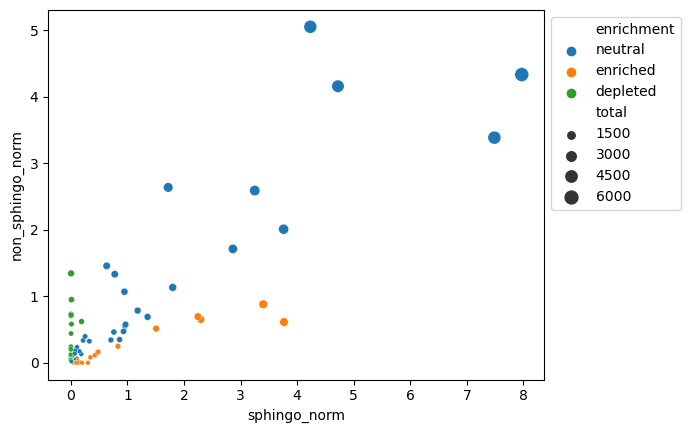

In [11]:
ax = sns.scatterplot(data=norm_df, x='sphingo_norm', y='non_sphingo_norm', size='total', hue='enrichment', sizes=(10, 100))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

norm_df.to_csv('cazymes_norm2_df.tsv', sep='\t')

#fig = visuz.GeneExpression.volcano(df=norm_df, lfc='log2FoldChange', pv='fisher_adj_pval', lfc_thr=(1.5,1.5), sign_line=True, figtype='pdf', figname='cazymes_volcano')

In [12]:
if not os.path.isfile('{}cazyme_per_genome.tsv'.format(output_dir)):
    cazyme_per_genome = pd.DataFrame(0, index=gene_cluster_presence_absence.index, columns=list(set(annotation_dict_CAZy_reformat.values())))

    for genome in sphingo_list:
        for GC in gene_cluster_presence_absence.columns:
            if gene_cluster_presence_absence.loc[genome, GC] == 1:
                if GC in annotation_dict_CAZy_reformat.keys():
                    cazyme = annotation_dict_CAZy_reformat[GC]
                    if cazyme != '-':
                        if ',' in cazyme:
                            try:
                                for caz in cazyme.split(','):
                                    cazyme_per_genome.loc[genome, caz] += 1
                            except KeyError:
                                cazyme_per_genome.loc[genome, cazyme] += 1
                        else:
                            cazyme_per_genome.loc[genome, cazyme] += 1

    for genome in non_sphingo_list:
        for GC in gene_cluster_presence_absence.columns:
            if gene_cluster_presence_absence.loc[genome, GC] == 1:
                if GC in annotation_dict_CAZy_reformat.keys():
                    cazyme = annotation_dict_CAZy_reformat[GC]
                    if cazyme != '-':
                        if ',' in cazyme:
                            try:
                                for caz in cazyme.split(','):
                                    cazyme_per_genome.loc[genome, caz] += 1
                            except KeyError:
                                cazyme_per_genome.loc[genome, cazyme] += 1
                        else:
                            cazyme_per_genome.loc[genome, cazyme] += 1


    cazyme_per_genome.to_csv('{}cazyme_per_genome.tsv'.format(output_dir), sep='\t')
else:
    cazyme_per_genome = pd.read_csv('{}cazyme_per_genome.tsv'.format(output_dir), sep='\t', index_col=0)


In [13]:
# drop the columns with all zeros from cazyme_per_genome
cazyme_per_genome = cazyme_per_genome.loc[:, (cazyme_per_genome != 0).any(axis=0)]

#print (cazyme_per_genome)

wilcoxon_ranksum_df = pd.DataFrame(0, index=cazyme_per_genome.columns, columns=['sphingo_average', 'non_sphingo_average', 'pvalue', 'adj_pval' ,'enrichment'])

for cazyme in cazyme_per_genome.columns:
    wilcoxon_ranksum_df.loc[cazyme, 'sphingo_average'] = cazyme_per_genome.loc[sphingo_list, cazyme].mean()
    wilcoxon_ranksum_df.loc[cazyme, 'non_sphingo_average'] = cazyme_per_genome.loc[non_sphingo_list, cazyme].mean()
    wilcoxon_ranksum_df.loc[cazyme, 'pvalue'] = stats.mannwhitneyu(cazyme_per_genome.loc[sphingo_list, cazyme], cazyme_per_genome.loc[non_sphingo_list, cazyme])[1]
    
adj_pval = multipletests(wilcoxon_ranksum_df.loc[:, 'pvalue'], alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)
wilcoxon_ranksum_df.loc[:, 'adj_pval'] = adj_pval[1]

for cazyme in wilcoxon_ranksum_df.index:
    if wilcoxon_ranksum_df.loc[cazyme, 'adj_pval'] < 0.05:
        if wilcoxon_ranksum_df.loc[cazyme, 'sphingo_average'] > wilcoxon_ranksum_df.loc[cazyme, 'non_sphingo_average']:
            wilcoxon_ranksum_df.loc[cazyme, 'enrichment'] = 'enriched'
        elif wilcoxon_ranksum_df.loc[cazyme, 'sphingo_average'] < wilcoxon_ranksum_df.loc[cazyme, 'non_sphingo_average']:
            wilcoxon_ranksum_df.loc[cazyme, 'enrichment'] = 'depleted'
    else:
        wilcoxon_ranksum_df.loc[cazyme, 'enrichment'] = 'neutral'


In [14]:
cazyme_per_genome
wilcoxon_ranksum_df

,sphingo_average,non_sphingo_average,pvalue,adj_pval,enrichment
"AA10,CBM73,GH5,GH9",0.114286,0.032298,6.702587e-09,5.295043e-07,enriched
GH23,0.947253,1.068323,1.600365e-02,1.000000e+00,neutral
"CBM42,GH54",0.000000,0.032298,1.080342e-04,8.534704e-03,depleted
GH47,0.037363,0.012422,3.335571e-03,2.635101e-01,neutral
GT2,5.008791,6.382609,1.385080e-06,1.094214e-04,depleted
...,...,...,...,...,...
GH38,0.000000,0.068323,1.205824e-08,9.526012e-07,depleted
GH57,0.061538,0.039752,8.126769e-02,1.000000e+00,neutral
"GH4,GT4",0.000000,0.052174,7.294710e-07,5.762821e-05,depleted
GT35,0.958242,0.559006,1.029089e-49,8.129803e-48,enriched


In [15]:
wilcoxon_ranksum_df

for cazyme in cazyme_per_genome.columns:
    if wilcoxon_ranksum_df.loc[cazyme, 'enrichment'] == 'enriched':
        print (cazyme, wilcoxon_ranksum_df.loc[cazyme, 'adj_pval'], cazyme_per_genome.loc[sphingo_list, cazyme].mean(), cazyme_per_genome.loc[non_sphingo_list, cazyme].mean())
        if not os.path.isfile('{}plots/cazymes/enriched_{}.pdf'.format(output_dir, cazyme)):
            plotting_data = pd.DataFrame(pd.concat([cazyme_per_genome.loc[sphingo_list, cazyme], cazyme_per_genome.loc[non_sphingo_list, cazyme]], axis=0))
            plotting_data.columns = ['cazyme per genome']
            T = ['sphingo'] * len(sphingo_list) + ['non_sphingo'] * len(non_sphingo_list)
            plotting_data.loc[:, 'taxa'] = T
            
            #vertical stacked histogram
            g = sns.FacetGrid(plotting_data, row='taxa', sharex=True, sharey=True, hue='taxa', palette='Set1', height=5, aspect=1.5, margin_titles=True)
            g.map(sns.histplot, 'cazyme per genome', bins=max(plotting_data.loc[:, 'cazyme per genome'])+1, discrete=True, shrink=0.9)
            g.axes.flat[0].axvline(cazyme_per_genome.loc[sphingo_list, cazyme].mean(), ls='--', color='black', lw=3)
            g.axes.flat[1].axvline(cazyme_per_genome.loc[non_sphingo_list, cazyme].mean(), ls='--', color='black', lw=3)
            #set the xtixks to be integers
            for ax in g.axes.flat:
                ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            #set cazyme as title
            g.fig.subplots_adjust(top=0.9)
            g.fig.suptitle('{}'.format(cazyme), fontsize=16)

        
            plt.savefig('{}plots/cazymes/enriched_{}.pdf'.format(output_dir, cazyme), bbox_inches='tight')
            plt.show()

    elif wilcoxon_ranksum_df.loc[cazyme, 'enrichment'] == 'depleted':
        print (cazyme, wilcoxon_ranksum_df.loc[cazyme, 'adj_pval'], cazyme_per_genome.loc[sphingo_list, cazyme].mean(), cazyme_per_genome.loc[non_sphingo_list, cazyme].mean())
        if not os.path.isfile('{}plots/cazymes/depleted_{}.pdf'.format(output_dir, cazyme)):

            plotting_data = pd.DataFrame(pd.concat([cazyme_per_genome.loc[sphingo_list, cazyme], cazyme_per_genome.loc[non_sphingo_list, cazyme]], axis=0))
            plotting_data.columns = ['cazyme per genome']
            T = ['sphingo'] * len(sphingo_list) + ['non_sphingo'] * len(non_sphingo_list)
            plotting_data.loc[:, 'taxa'] = T

            #vertical stacked histogram
            g = sns.FacetGrid(plotting_data, row='taxa', sharex=True, sharey=True, hue='taxa', palette='Set1', height=5, aspect=1.5, margin_titles=True)
            g.map(sns.histplot, 'cazyme per genome', bins=max(plotting_data.loc[:, 'cazyme per genome'])+1, discrete=True, shrink=0.9)
            g.axes.flat[0].axvline(cazyme_per_genome.loc[sphingo_list, cazyme].mean(), ls='--', color='black', lw=3)
            g.axes.flat[1].axvline(cazyme_per_genome.loc[non_sphingo_list, cazyme].mean(), ls='--', color='black', lw=3)
            #set the xtixks to be integers
            for ax in g.axes.flat:
                ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            #set cazyme as title
            g.fig.subplots_adjust(top=0.9)
            g.fig.suptitle('{}'.format(cazyme), fontsize=16)

            plt.savefig('{}plots/cazymes/depleted_{}.pdf'.format(output_dir, cazyme), bbox_inches='tight')
            plt.show()


AA10,CBM73,GH5,GH9 5.295043478017259e-07 0.11428571428571428 0.03229813664596273
CBM42,GH54 0.008534704249334083 0.0 0.03229813664596273
GT2 0.00010942135922865592 5.008791208791209 6.3826086956521735
GH37 1.3402707068388432e-66 0.8615384615384616 0.3490683229813665
GH8 2.469751244554274e-32 0.26593406593406593 0.8037267080745342
GH88 0.018588464552890996 0.026373626373626374 0.08074534161490683
GH102 1.8398697959392804e-57 0.9318681318681319 0.4720496894409938
PL4 2.1510290117136083e-23 0.0 0.2062111801242236
GH28 4.217513997337221e-28 0.17582417582417584 0.007453416149068323
PL8 0.000961608179582528 0.0 0.040993788819875775
GT26 0.004415501514302022 0.2175824175824176 0.33664596273291925
GT30 2.414546741214356e-125 0.002197802197802198 0.7055900621118012
GH5 2.1114120381145366e-32 2.465934065934066 1.5167701863354037
GT19 3.429320148916535e-129 0.004395604395604396 0.7167701863354037
GT4 3.12705947624057e-44 8.854945054945055 5.6645962732919255
GT5 6.417304942181728e-67 1.35604395604

In [16]:
#repeat cazyme analysis for KEGG
if not os.path.isfile('{}parsed_dbs/kegg_per_genome.tsv'.format(output_dir)):
    kegg_per_genome.to_csv('{}parsed_dbs/kegg_per_genome.tsv'.format(output_dir), sep='\t')

    kegg_per_genome = pd.DataFrame(0, index=gene_cluster_presence_absence.index, columns=list(set(annotation_dict_KEGG_reformat.values())))
    for genome in sphingo_list:
        for GC in gene_cluster_presence_absence.columns:
            if gene_cluster_presence_absence.loc[genome, GC] == 1:
                if GC in annotation_dict_KEGG_reformat.keys():
                    kegg = annotation_dict_KEGG_reformat[GC]
                    if kegg != '-':
                        if ',' in kegg:
                            try:
                                for k in kegg.split(','):
                                    kegg_per_genome.loc[genome, k] += 1
                            except KeyError:
                                kegg_per_genome.loc[genome, kegg] += 1
                        else:
                            kegg_per_genome.loc[genome, kegg] += 1


    for genome in non_sphingo_list:
        for GC in gene_cluster_presence_absence.columns:
            if gene_cluster_presence_absence.loc[genome, GC] == 1:
                if GC in annotation_dict_KEGG_reformat.keys():
                    kegg = annotation_dict_KEGG_reformat[GC]
                    if kegg != '-':
                        if ',' in kegg:
                            try:
                                for k in kegg.split(','):
                                    kegg_per_genome.loc[genome, k] += 1
                            except KeyError:
                                kegg_per_genome.loc[genome, kegg] += 1
                        else:
                            kegg_per_genome.loc[genome, kegg]  += 1

    print (kegg_per_genome)
    
else:
    print ('{}parsed_dbs/kegg_per_genome.tsv already exists'.format(output_dir))
    kegg_per_genome = pd.read_csv('{}parsed_dbs/kegg_per_genome.tsv'.format(output_dir), sep='\t', index_col=0)

kegg_per_genome_sum = kegg_per_genome.sum(axis=0)


/DATA_RAID2/vtracann/shared/db/isolates/parsed_dbs/kegg_per_genome.tsv already exists


In [17]:
sphingo_kegg = {k: 0 for k in kegg_per_genome_sum.index}
non_sphingo_kegg = {k: 0 for k in kegg_per_genome_sum.index}

for genome in sphingo_list:
    for kegg in kegg_per_genome_sum.index:
        sphingo_kegg[kegg] += kegg_per_genome.loc[genome, kegg]

for genome in non_sphingo_list:
    for kegg in kegg_per_genome_sum.index:
        non_sphingo_kegg[kegg] += kegg_per_genome.loc[genome, kegg]

norm_sphingo_kegg = pd.Series(sphingo_kegg)/len(sphingo_list)
norm_non_sphingo_kegg = pd.Series(non_sphingo_kegg)/len(non_sphingo_list)

chisquare_df = pd.DataFrame([sphingo_kegg, non_sphingo_kegg], index=['sphingo', 'non_sphingo'])

norm_df = pd.DataFrame([norm_sphingo_kegg, norm_non_sphingo_kegg, pd.Series(sphingo_kegg), pd.Series(non_sphingo_kegg)], index=['sphingo_norm', 'non_sphingo_norm', 'sphingo', 'non_sphingo']).transpose()

for kegg in norm_df.index:
    #print ([norm_df.loc[kegg, 'sphingo'], norm_df.loc[kegg, 'non_sphingo']], [norm_df.loc[:, 'sphingo'].sum(), norm_df.loc[:, 'non_sphingo'].sum()])
    fisher_exact = stats.fisher_exact([[norm_df.loc[kegg, 'sphingo'], norm_df.loc[kegg, 'non_sphingo']], [norm_df.loc[:, 'sphingo'].sum(), norm_df.loc[:, 'non_sphingo'].sum()]])
    norm_df.loc[kegg, 'fisher_odds_ratio'] = fisher_exact[0]
    norm_df.loc[kegg, 'fisher_pvalue'] = fisher_exact[1]

adj_pval = multipletests(norm_df.loc[:, 'fisher_pvalue'], alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)
norm_df.loc[:, 'fisher_adj_pval'] = adj_pval[1]
norm_df.loc[:, 'log2FoldChange'] = np.log2(norm_df.loc[:, 'sphingo_norm'])-np.log2(norm_df.loc[:, 'non_sphingo_norm'])
norm_df.loc[:, 'total'] = norm_df.loc[:, 'sphingo'] + norm_df.loc[:, 'non_sphingo']

print (norm_df)

for kegg in norm_df.index:
    if norm_df.loc[kegg, 'fisher_adj_pval'] < 0.05:
        if norm_df.loc[kegg, 'log2FoldChange'] > 1.5:
            norm_df.loc[kegg, 'enrichment'] = 'enriched'
        elif norm_df.loc[kegg, 'log2FoldChange'] < -1.5:
            norm_df.loc[kegg, 'enrichment'] = 'depleted'
        else:
            norm_df.loc[kegg, 'enrichment'] = 'neutral'
    else:
        norm_df.loc[kegg, 'enrichment'] = 'neutral'


/home/vtracann/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


                     sphingo_norm  non_sphingo_norm  sphingo  non_sphingo   
ko:K10564                0.000000          0.094410      0.0         76.0  \
ko:K00493                0.936264          0.416149    426.0        335.0   
ko:K07643,ko:K07645      0.000000          0.042236      0.0         34.0   
ko:K06183                0.000000          0.840994      0.0        677.0   
ko:K20331                0.000000          0.109317      0.0         88.0   
...                           ...               ...      ...          ...   
ko:K10943                0.927473          0.360248    422.0        290.0   
ko:K03564                0.890110          1.062112    405.0        855.0   
ko:K14051                0.000000          0.055901      0.0         45.0   
ko:K18138                1.345055          2.309317    612.0       1859.0   
ko:K05396                0.004396          0.515528      2.0        415.0   

                     fisher_odds_ratio  fisher_pvalue  fisher_adj_pval   
k

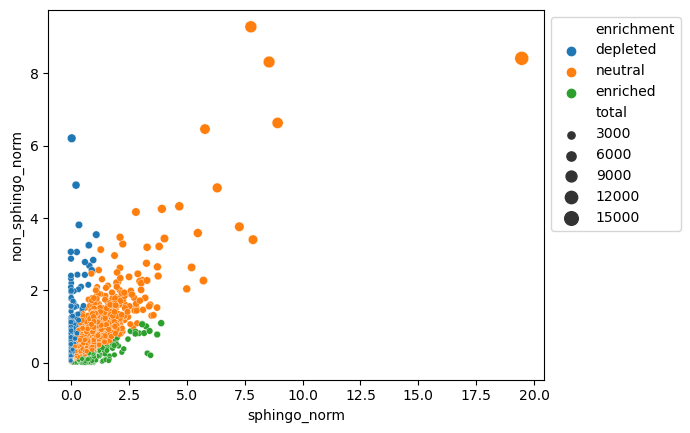

In [18]:
ax = sns.scatterplot(data=norm_df, x='sphingo_norm', y='non_sphingo_norm', size='total', hue='enrichment', sizes=(10, 100))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

#fig = visuz.GeneExpression.volcano(df=norm_df, lfc='log2FoldChange', pv='fisher_adj_pval', lfc_thr=(1.5,1.5), sign_line=True, figtype='pdf', figname='kegg_volcano')

In [19]:
# drop the columns with all zeros from kegg_per_genome
kegg_per_genome = kegg_per_genome.loc[:, (kegg_per_genome != 0).any(axis=0)]

#print (kegg_per_genome)

wilcoxon_ranksum_df = pd.DataFrame(0, index=kegg_per_genome.columns, columns=['sphingo_average', 'non_sphingo_average', 'pvalue', 'adj_pval' ,'enrichment'])

for kegg in kegg_per_genome.columns:
    wilcoxon_ranksum_df.loc[kegg, 'sphingo_average'] = kegg_per_genome.loc[sphingo_list, kegg].mean()
    wilcoxon_ranksum_df.loc[kegg, 'non_sphingo_average'] = kegg_per_genome.loc[non_sphingo_list, kegg].mean()
    wilcoxon_ranksum_df.loc[kegg, 'pvalue'] = stats.mannwhitneyu(kegg_per_genome.loc[sphingo_list, kegg], kegg_per_genome.loc[non_sphingo_list, kegg])[1]
    
adj_pval = multipletests(wilcoxon_ranksum_df.loc[:, 'pvalue'], alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)
wilcoxon_ranksum_df.loc[:, 'adj_pval'] = adj_pval[1]

for kegg in wilcoxon_ranksum_df.index:
    if wilcoxon_ranksum_df.loc[kegg, 'adj_pval'] < 0.05:
        if wilcoxon_ranksum_df.loc[kegg, 'sphingo_average'] > wilcoxon_ranksum_df.loc[kegg, 'non_sphingo_average']:
            wilcoxon_ranksum_df.loc[kegg, 'enrichment'] = 'enriched'
        elif wilcoxon_ranksum_df.loc[kegg, 'sphingo_average'] < wilcoxon_ranksum_df.loc[kegg, 'non_sphingo_average']:
            wilcoxon_ranksum_df.loc[kegg, 'enrichment'] = 'depleted'
    else:
        wilcoxon_ranksum_df.loc[kegg, 'enrichment'] = 'neutral'

print (wilcoxon_ranksum_df)

                     sphingo_average  non_sphingo_average         pvalue   
ko:K10564                   0.000000             0.094410   1.395971e-11  \
ko:K00493                   0.936264             0.416149   4.178598e-70   
ko:K07643,ko:K07645         0.000000             0.042236   8.909174e-06   
ko:K06183                   0.000000             0.840994  1.479035e-166   
ko:K20331                   0.000000             0.109317   2.681505e-13   
...                              ...                  ...            ...   
ko:K10943                   0.927473             0.360248   7.082335e-78   
ko:K03564                   0.890110             1.062112   2.124166e-21   
ko:K14051                   0.000000             0.055901   2.843322e-07   
ko:K18138                   1.345055             2.309317   1.000503e-24   
ko:K05396                   0.004396             0.515528   1.527691e-55   

                          adj_pval enrichment  
ko:K10564             7.499155e-08   de

In [20]:
coverage = pd.DataFrame(0, index=kegg_per_genome.columns, columns=['sphingo', 'non_sphingo'])

for kegg in kegg_per_genome.columns:
    coverage.loc[kegg, 'sphingo'] = kegg_per_genome.loc[sphingo_list, kegg].sum()/len(sphingo_list)
    coverage.loc[kegg, 'non_sphingo'] = kegg_per_genome.loc[non_sphingo_list, kegg].sum()/len(non_sphingo_list)

print (coverage)

divergence = coverage.loc[:, 'sphingo']/coverage.loc[:, 'non_sphingo']
print (divergence)

average_divergence = divergence.mean()
print (average_divergence)

                      sphingo  non_sphingo
ko:K10564            0.000000     0.094410
ko:K00493            0.936264     0.416149
ko:K07643,ko:K07645  0.000000     0.042236
ko:K06183            0.000000     0.840994
ko:K20331            0.000000     0.109317
...                       ...          ...
ko:K10943            0.927473     0.360248
ko:K03564            0.890110     1.062112
ko:K14051            0.000000     0.055901
ko:K18138            1.345055     2.309317
ko:K05396            0.004396     0.515528

[5372 rows x 2 columns]
ko:K10564              0.000000
ko:K00493              2.249828
ko:K07643,ko:K07645    0.000000
ko:K06183              0.000000
ko:K20331              0.000000
                         ...   
ko:K10943              2.574536
ko:K03564              0.838057
ko:K14051              0.000000
ko:K18138              0.582447
ko:K05396              0.008526
Length: 5372, dtype: float64
inf


In [21]:
def train_test_split(gene_cluster_presence_absence, taxa, test_frac):
    #split gene_cluster_presence_absence into training and test set based on test_size
    #test_size is the proportion of the dataset that is allocated to the test set
    #the training set is the complement of the test set
    #gene_cluster_presence_absence is a dataframe with genomes as rows and gene clusters as columns
    #taxa is a dataframe with genomes as rows and taxonomy as columns
    #returns taxa of the test set and training set
    #returns gene_cluster_presence_absence of the test set and training set

    test_size = int(len(gene_cluster_presence_absence.index)*test_frac)
    test_set = random.sample(list(gene_cluster_presence_absence.index), test_size)
    training_set = [x for x in gene_cluster_presence_absence.index if x not in test_set]
    
    test_taxa = taxa.loc[test_set]
    test_taxa = [1 if x == 'Sphingomonadaceae' else 0 for x in test_taxa.loc[:, 1]]
    training_taxa = taxa.loc[training_set]
    training_taxa = [1 if x == 'Sphingomonadaceae' else 0 for x in training_taxa.loc[:, 1]]
    test_gene_cluster_presence_absence = gene_cluster_presence_absence.loc[test_set, :]
    training_gene_cluster_presence_absence = gene_cluster_presence_absence.loc[training_set, :]

    return training_gene_cluster_presence_absence, training_taxa, test_gene_cluster_presence_absence, test_taxa  

#print (cluster_id_to_feature_ids)
#print (dict(cluster_id_to_feature_ids))

import pickle
if not os.path.isfile('{}cluster_id_to_feature_ids.pkl'.format(output_dir)):
    with open('{}cluster_id_to_feature_ids.pkl'.format(output_dir), 'wb') as f:
        pickle.dump(dict(cluster_id_to_feature_ids), f)

else:
    cluster_id_to_feature_ids2 = pickle.load(open('{}cluster_id_to_feature_ids.pkl'.format(output_dir), 'rb'))

print (cluster_id_to_feature_ids2)

{18602: [0], 18510: [1], 17472: [2], 17547: [3], 7469: [4], 6053: [5], 6282: [6, 9], 17540: [7, 941], 12319: [8], 6283: [10], 17032: [11], 6287: [12], 2974: [13], 13647: [14], 18727: [15], 6366: [16], 6320: [17], 2430: [18], 17473: [19], 3979: [20], 12716: [21], 6318: [22], 10435: [23], 18513: [24], 2811: [25], 2288: [26], 15044: [27], 6298: [28], 6360: [29, 190, 267, 272, 275, 280, 283, 286, 287, 288, 290, 293, 294, 3946, 4283], 6753: [30, 59, 199, 210, 7248, 8108, 8111, 8131, 8184, 8263, 8303, 8376, 8411, 8424, 8486], 18470: [31], 10443: [32], 10299: [33], 5839: [34], 6389: [35], 13170: [36, 2126], 18521: [37], 2417: [38], 17033: [39], 18518: [40], 6846: [41], 9146: [42], 13679: [43], 18660: [44], 6291: [45], 18664: [46], 18475: [47], 18739: [48], 13705: [49, 191, 316, 453, 504, 544, 584, 594, 641, 664, 718, 721, 738, 762, 768, 774, 775, 777, 779, 782, 785, 786, 787, 791, 794, 795, 796, 798, 799, 800, 801, 808, 809, 810, 811, 812, 813, 814, 815, 816, 818, 819, 820, 823, 824, 825, 827

0.996031746031746
item
GC_00001622    1.0
GC_00000001    0.0
GC_00024837    0.0
GC_00024831    0.0
GC_00024832    0.0
              ... 
GC_00024739    0.0
GC_00024740    0.0
GC_00024741    0.0
GC_00024742    0.0
GC_00024743    0.0
Length: 100, dtype: float64
0.0
18531.0
1.0
item
GC_00001929    0.003090
GC_00002064    0.003081
GC_00001685    0.003031
GC_00001935    0.002995
GC_00001577    0.002984
                 ...   
GC_00001474    0.002839
GC_00001542    0.002835
GC_00001443    0.002831
GC_00002020    0.002820
GC_00001150    0.002811
Length: 100, dtype: float64
0.002911119974156058
45.0


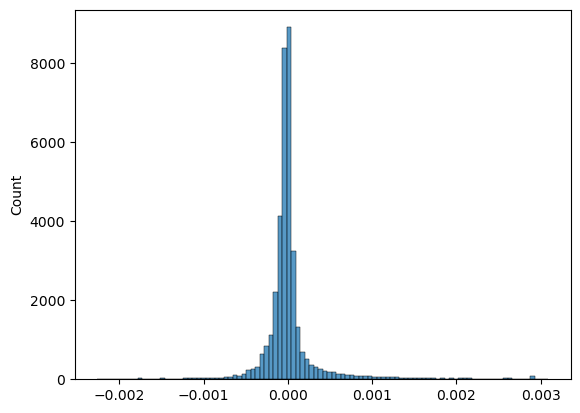

1.0
item
GC_00001479    0.018769
GC_00001574    0.018769
GC_00001554    0.018769
GC_00001622    0.018769
GC_00001513    0.018769
                 ...   
GC_00001505    0.018618
GC_00001580    0.018567
GC_00001329    0.018540
GC_00001929    0.018526
GC_00001767    0.018494
Length: 100, dtype: float64
0.01876860902407546
37.0


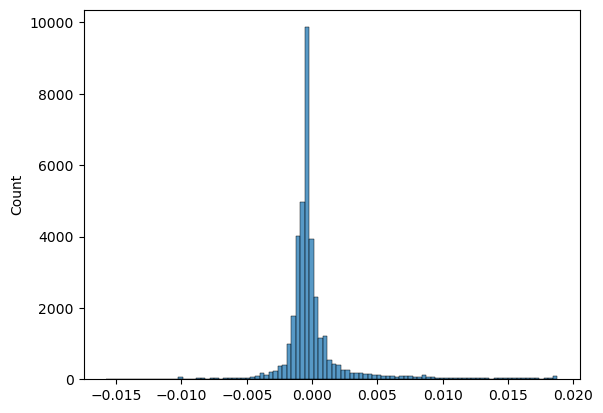

In [22]:
#decision tree with taxa labels binary and gc_matrix
taxa_labels = [1 if x == 'Sphingomonadaceae' else 0 for x in taxa_df.loc[gene_cluster_presence_absence.index, 1]]
gc_matrix = gene_cluster_presence_absence.values

#taxa_labels = ['Sphingomonadaceae' if x == 'Sphingomonadaceae' else 'Other' for x in taxa_df.loc[:, 1]]

X_train, X_test, y_train, y_test = tts(gc_matrix, taxa_labels, test_size=0.2)

#train the model
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)

#predict the test set
y_pred = clf.predict(X_test)
 
print (accuracy_score(y_test, y_pred))

importances = clf.feature_importances_
#std = np.std([clf.feature_importances_ for tree in clf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=gene_cluster_presence_absence.columns)
forest_ranked = forest_importances.rank(ascending=False)
print (forest_importances.sort_values(ascending=False)[:100])
print (forest_importances.loc['GC_00001531'])
print (forest_ranked.loc['GC_00001531'])


#print (forest_importances.loc['GC_00001531'])
'''
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
'''

#create classifier using ridgeclassifier
from sklearn.linear_model import RidgeClassifier
clf = RidgeClassifier().fit(X_train, y_train)
y_pred = clf.predict(X_test)
print (accuracy_score(y_test, y_pred))
importances = clf.coef_
ridge_importances = pd.Series(importances[0], index=gene_cluster_presence_absence.columns)
ridge_ranked = ridge_importances.rank(ascending=False)
print (ridge_importances.sort_values(ascending=False)[:100])
print (ridge_importances.loc['GC_00001531'])
print (ridge_ranked.loc['GC_00001531'])

sns.histplot(ridge_importances, bins=100)
plt.show()

#create classifier using logistic regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print (accuracy_score(y_test, y_pred))
importances = clf.coef_
logReg_importances = pd.Series(importances[0], index=gene_cluster_presence_absence.columns)
logReg_ranked = logReg_importances.rank(ascending=False)
print (logReg_importances.sort_values(ascending=False)[:100])
print (logReg_importances.loc['GC_00001531'])
print (logReg_ranked.loc['GC_00001531'])

sns.histplot(logReg_importances, bins=100)
plt.show()

In [23]:
'''#decision tree with taxa labels binary and dataframe

X_train, y_train, x_test, y_test = train_test_split(gene_cluster_presence_absence, taxa_df, test_frac=0.2)

forest = RandomForestClassifier()
forest.fit(X_train, y_train)

y_pred = clf.predict(X_test)

#evaluate the model
print (accuracy_score(y_test, y_pred))

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

print (X_train)

forest_importances = pd.Series(importances, index=X_train.columns)
print (forest_importances.sort_values(ascending=False)[:100])
print (forest_importances.loc['GC_00001531'])
'''

"#decision tree with taxa labels binary and dataframe\n\nX_train, y_train, x_test, y_test = train_test_split(gene_cluster_presence_absence, taxa_df, test_frac=0.2)\n\nforest = RandomForestClassifier()\nforest.fit(X_train, y_train)\n\ny_pred = clf.predict(X_test)\n\n#evaluate the model\nprint (accuracy_score(y_test, y_pred))\n\nimportances = forest.feature_importances_\nstd = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)\n\nprint (X_train)\n\nforest_importances = pd.Series(importances, index=X_train.columns)\nprint (forest_importances.sort_values(ascending=False)[:100])\nprint (forest_importances.loc['GC_00001531'])\n"

In [24]:
#result = permutation_importance(forest, X_test, y_test, n_repeats=2, random_state=42)
#forest_importances = pd.Series(result.importances_mean, index=feature_names)

#One approach to handling multicollinearity is by performing hierarchical clustering on the features’ Spearman rank-order correlations, picking a threshold, and keeping a single feature from each cluster.
#here we run the correlation or load it from a file
#if not os.path.isfile('{}correlation.tsv'.format(output_dir)):
#    spearman_corr = spearmanr(gene_cluster_presence_absence).correlation
#    spearman_corr.to_csv('{}spearman_corr.tsv'.format(output_dir), sep='\t')
#else:
#    spearman_corr = pd.read_csv('{}spearman_corr.tsv'.format(output_dir), sep='\t', index_col=0)


In [25]:
if not os.path.isfile('{}spearman_corr.pkl'.format(output_dir)):
    spearman_corr = spearmanr(gene_cluster_presence_absence).correlation
    with open('{}spearman_corr.pkl'.format(output_dir), 'wb') as f:
        pickle.dump(spearman_corr, f)
else:
    spearman_corr = pickle.load(open('{}spearman_corr.pkl'.format(output_dir), 'rb'))

#spearman_corr = pd.read_csv('{}spearman_corr.tsv'.format(output_dir), sep='\t', index_col=0)

print (spearman_corr)
spearman_corr = np.array(spearman_corr)
print (spearman_corr)

corr = (spearman_corr + spearman_corr.T) / 2
np.fill_diagonal(corr, 1)

distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))

[[ 1.          0.03161103  0.03839606 ... -0.14244776 -0.14244776
  -0.12966398]
 [ 0.03161103  1.         -0.02858853 ...  0.00357924  0.00357924
   0.00357924]
 [ 0.03839606 -0.02858853  1.         ...  0.12882756 -0.12519862
   0.12882756]
 ...
 [-0.14244776  0.00357924  0.12882756 ...  1.         -0.01612903
   0.18709677]
 [-0.14244776  0.00357924 -0.12519862 ... -0.01612903  1.
  -0.01612903]
 [-0.12966398  0.00357924  0.12882756 ...  0.18709677 -0.01612903
   1.        ]]
[[ 1.          0.03161103  0.03839606 ... -0.14244776 -0.14244776
  -0.12966398]
 [ 0.03161103  1.         -0.02858853 ...  0.00357924  0.00357924
   0.00357924]
 [ 0.03839606 -0.02858853  1.         ...  0.12882756 -0.12519862
   0.12882756]
 ...
 [-0.14244776  0.00357924  0.12882756 ...  1.         -0.01612903
   0.18709677]
 [-0.14244776  0.00357924 -0.12519862 ... -0.01612903  1.
  -0.01612903]
 [-0.12966398  0.00357924  0.12882756 ...  0.18709677 -0.01612903
   1.        ]]


In [26]:
'''
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

dendro = hierarchy.dendrogram(dist_linkage, labels=gene_cluster_presence_absence.columns.tolist(), ax=ax1, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()
'''
if not os.path.isfile('{}spearman_corr.tsv'.format(output_dir)):
    np.savetxt('{}spearman_corr.tsv'.format(output_dir), spearman_corr, delimiter='\t')

In [27]:
cluster_ids = hierarchy.fcluster(dist_linkage, t=0.05, criterion="distance")
print (cluster_ids)
print (len(set(cluster_ids))/len(dist_linkage))

cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)

selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
clusters_in_use = len(cluster_id_to_feature_ids.keys())
features_to_cluster = pd.Series()

for cluster in range(len(cluster_ids)):
    features_to_cluster.loc[gene_cluster_presence_absence.columns[cluster]] = cluster_ids[cluster]

#given the absolute 
for cluster in range(1, len(cluster_id_to_feature_ids)):
    if len(cluster_id_to_feature_ids[cluster])>1:
        clustercorr = spearmanr(gene_cluster_presence_absence.iloc[:, cluster_id_to_feature_ids[cluster]]).correlation
        directionality = np.sign(clustercorr)
        if isinstance(directionality, np.ndarray):
            directionality = directionality[0]
            if -1 in directionality:
                old_cluster = [cluster_id_to_feature_ids[cluster][i] for i, x in enumerate(directionality) if x == 1]
                new_cluster = [cluster_id_to_feature_ids[cluster][i] for i, x in enumerate(directionality) if x == -1]
                cluster_id_to_feature_ids[cluster] = old_cluster
                cluster_id_to_feature_ids[len(cluster_id_to_feature_ids.keys())+1] = new_cluster
                clusters_in_use +=1

        elif isinstance(directionality, np.float64):
            if directionality < 0:
                print (cluster_id_to_feature_ids[cluster])
                clusters_in_use +=1
                cluster_id_to_feature_ids[clusters_in_use] = [cluster_id_to_feature_ids[cluster][1]]
                cluster_id_to_feature_ids[cluster] = [cluster_id_to_feature_ids[cluster][0]]
                print (cluster_id_to_feature_ids[clusters_in_use])
                print (cluster_id_to_feature_ids[cluster])

print (cluster_ids)
print (len(cluster_id_to_feature_ids)/len(dist_linkage))

#X_train_sel = X_train[:, selected_features]
#X_test_sel = X_test[:, selected_features]

selected_features_columns = [gene_cluster_presence_absence.columns[v[0]] for v in cluster_id_to_feature_ids.values()]
print (features_to_cluster)


[18602 18510 17472 ...  5430 12020  7253]
0.5340133300952535
[597, 974]
[974]
[597]
[18602 18510 17472 ...  5430 12020  7253]
0.5342831700801425
GC_00000001    18602
GC_00000002    18510
GC_00000003    17472
GC_00000004    17547
GC_00000005     7469
               ...  
GC_00038550     5430
GC_00038551    11026
GC_00038554     5430
GC_00038559    12020
GC_00038560     7253
Length: 37060, dtype: int32


In [28]:
#print columns corresponding to each key in cluster_id_to_feature_ids
for key in cluster_id_to_feature_ids.keys():
    if 'GC_00001531' in [gene_cluster_presence_absence.columns[i] for i in cluster_id_to_feature_ids[key]]:
        print (key, [gene_cluster_presence_absence.columns[i] for i in cluster_id_to_feature_ids[key]])
        clustered_GCs = [gene_cluster_presence_absence.columns[i] for i in cluster_id_to_feature_ids[key]]
    if 'GC_00001292' in [gene_cluster_presence_absence.columns[i] for i in cluster_id_to_feature_ids[key]]:
        clustered_GCs2 = [gene_cluster_presence_absence.columns[i] for i in cluster_id_to_feature_ids[key]]


cl1 = spearmanr(gene_cluster_presence_absence.loc[:, clustered_GCs]).correlation
cl2 = spearmanr(gene_cluster_presence_absence.loc[:, clustered_GCs2]).correlation
cl12 = spearmanr(gene_cluster_presence_absence.loc[:, clustered_GCs], gene_cluster_presence_absence.loc[:, clustered_GCs2]).correlation

#cl1 and cl2 are highly correlated. this implies that the selection still needs work. both should be high in the list. I have to implement again the "leave one out" approach
print (cl1.shape)
print (cl2.shape)
print (cl12.shape)
with np.printoptions(threshold=np.inf):
    print (cl12)

#check the importance of GC_00001531 and GC_00001292 in the decision tree
print (forest_importances.loc['GC_00001292'])
print (forest_importances.loc['GC_00000402'])





13368 ['GC_00000402', 'GC_00001115', 'GC_00001185', 'GC_00001262', 'GC_00001289', 'GC_00001329', 'GC_00001352', 'GC_00001427', 'GC_00001438', 'GC_00001443', 'GC_00001447', 'GC_00001448', 'GC_00001456', 'GC_00001459', 'GC_00001460', 'GC_00001461', 'GC_00001469', 'GC_00001470', 'GC_00001474', 'GC_00001479', 'GC_00001480', 'GC_00001481', 'GC_00001482', 'GC_00001486', 'GC_00001488', 'GC_00001489', 'GC_00001490', 'GC_00001491', 'GC_00001492', 'GC_00001493', 'GC_00001495', 'GC_00001496', 'GC_00001497', 'GC_00001498', 'GC_00001499', 'GC_00001501', 'GC_00001502', 'GC_00001504', 'GC_00001505', 'GC_00001506', 'GC_00001507', 'GC_00001509', 'GC_00001510', 'GC_00001511', 'GC_00001512', 'GC_00001513', 'GC_00001514', 'GC_00001516', 'GC_00001517', 'GC_00001518', 'GC_00001519', 'GC_00001521', 'GC_00001522', 'GC_00001523', 'GC_00001529', 'GC_00001530', 'GC_00001531', 'GC_00001532', 'GC_00001533', 'GC_00001534', 'GC_00001535', 'GC_00001537', 'GC_00001538', 'GC_00001539', 'GC_00001540', 'GC_00001541', 'GC

1008 1008 252 252
19800 1008 19800 252
1.0
item
GC_00001829    0.029800
GC_00001744    0.027851
GC_00001929    0.021824
GC_00002152    0.020377
GC_00002189    0.019661
                 ...   
GC_00001820    0.001808
GC_00004009    0.001759
GC_00001089    0.001710
GC_00007846    0.001612
GC_00000363    0.001547
Length: 100, dtype: float64
0.009610864231422545
25.0


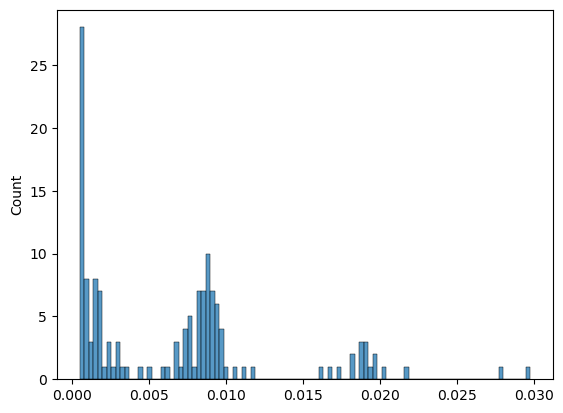

1.0
GC_00001935    0.007215
GC_00002236    0.007117
GC_00001929    0.007055
GC_00001294    0.006998
GC_00001150    0.006762
                 ...   
GC_00001335    0.004288
GC_00002406    0.004274
GC_00005803    0.004268
GC_00001958    0.004251
GC_00002160    0.004238
Length: 100, dtype: float64
0.004838763311271672
55.0


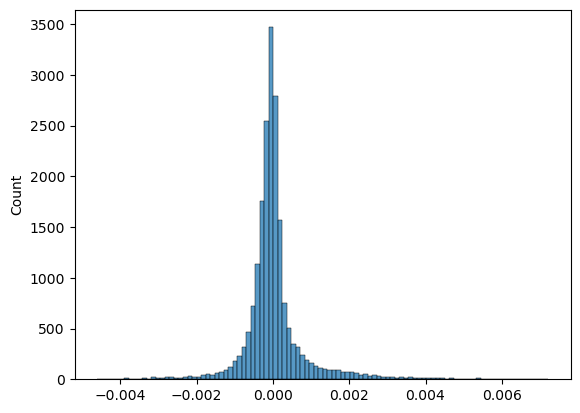

1.0
GC_00001294    0.039448
GC_00001929    0.039331
GC_00001935    0.038915
GC_00001318    0.038546
GC_00002161    0.038342
                 ...   
GC_00001617    0.029612
GC_00002900    0.029593
GC_00000402    0.029578
GC_00001342    0.029519
GC_00002358    0.029360
Length: 100, dtype: float64
0.029578155316890484
98.0


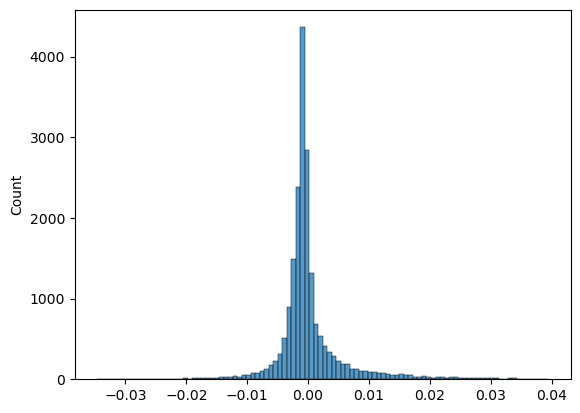

In [29]:
gene_cluster_presence_absence_sel = gene_cluster_presence_absence.loc[:, selected_features_columns]

X_train, y_train, x_test, y_test = train_test_split(gene_cluster_presence_absence_sel, taxa_df, test_frac=0.2)
print (len(X_train), len(y_train), len(x_test), len(y_test))
print (len(X_train.columns), len(y_train), len(x_test.columns), len(y_test))


forest = RandomForestClassifier()
forest.fit(X_train, y_train)
clf_tree = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)

y_pred = clf_tree.predict(x_test)

#evaluate the model
print (accuracy_score(y_test, y_pred))

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X_train.columns)
forest_rank_importances = forest_importances.rank(ascending=False)
print (forest_importances.sort_values(ascending=False)[:100])
print (forest_importances.loc['GC_00000402'])
print (forest_rank_importances['GC_00000402'])
forest_importances_red = forest_importances[forest_importances>0.0005]
sns.histplot(forest_importances_red, bins=100)
plt.show()

#create classifier using ridgeclassifier
from sklearn.linear_model import RidgeClassifier
clf = RidgeClassifier().fit(X_train, y_train)
y_pred = clf.predict(x_test)
print (accuracy_score(y_test, y_pred))
importances = clf.coef_
ridge_importances = pd.Series(importances[0], index=selected_features_columns)
ridge_rank_importances = ridge_importances.rank(ascending=False)
print (ridge_importances.sort_values(ascending=False)[:100])
print (ridge_importances.loc['GC_00000402'])
print (ridge_rank_importances['GC_00000402'])

sns.histplot(ridge_importances, bins=100)
plt.show()

#create classifier using logistic regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(x_test)
print (accuracy_score(y_test, y_pred))
importances = clf.coef_
logReg_importances = pd.Series(importances[0], index=selected_features_columns)
logReg_rank_importances = logReg_importances.rank(ascending=False)
print (logReg_importances.sort_values(ascending=False)[:100])
print (logReg_importances.loc['GC_00000402'])
print (logReg_rank_importances['GC_00000402'])

sns.histplot(logReg_importances, bins=100)
plt.show()



In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier

decision_tree_importance_dict = {}
ridge_importances_dict = {}
logReg_importances_dict = {}

#repeat the analysis 100 times and record the results (with different test and train test splits)
for iteration in range(1000):
    X_train, X_test, y_train, y_test = tts(gc_matrix, taxa_labels, test_size=0.2)

    #train the model
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    importances = clf.feature_importances_
    forest_importances = pd.Series(importances, index=gene_cluster_presence_absence.columns)
    forest_ranked = forest_importances.rank(ascending=False)
    decision_tree_importance_dict[iteration] = forest_importances

    #create classifier using ridgeclassifier
    clf = RidgeClassifier().fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    importances = clf.coef_
    ridge_importances = pd.Series(importances[0], index=gene_cluster_presence_absence.columns)
    ridge_ranked = ridge_importances.rank(ascending=False)
    ridge_importances_dict[iteration] = ridge_importances

    #create classifier using logistic regression
    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    importances = clf.coef_
    logReg_importances = pd.Series(importances[0], index=gene_cluster_presence_absence.columns)
    logReg_ranked = logReg_importances.rank(ascending=False)
    logReg_importances_dict[iteration] = logReg_importances
    

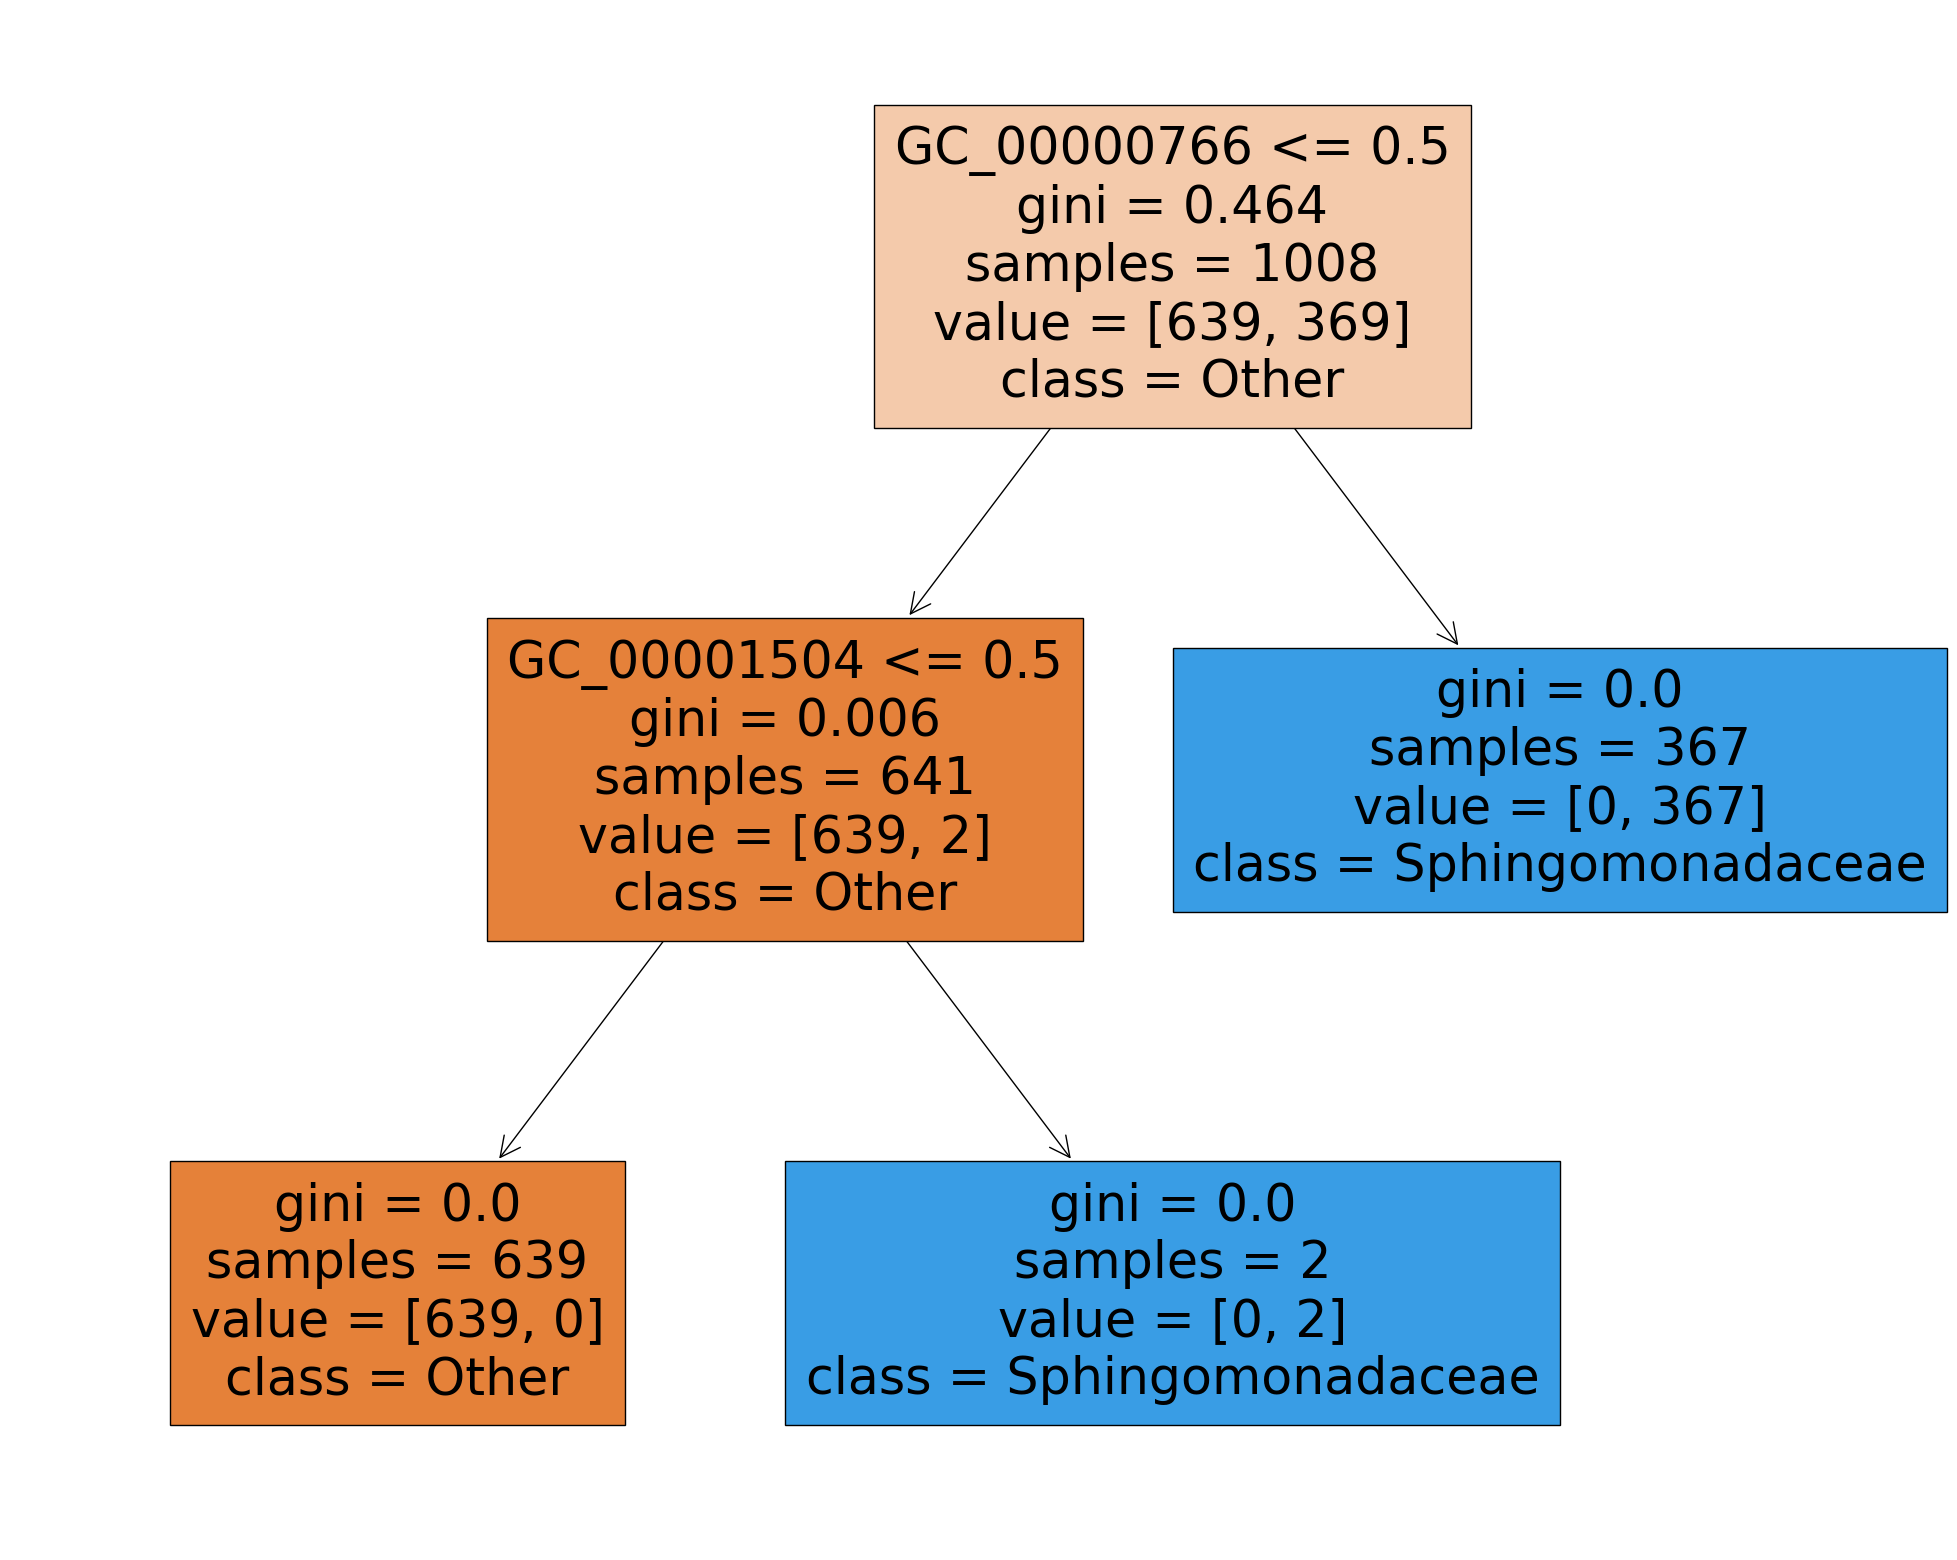

1.0
0.0
S
Virul_fac_BrkB
ribonuclease BN
ko:K07058


In [31]:
#plot the decision tree
# find out which one gave always the same result

from sklearn.tree import plot_tree

fig = plt.figure(figsize=(25,20))
fig = plot_tree(clf_tree, feature_names=gene_cluster_presence_absence.columns, class_names=['Other', 'Sphingomonadaceae'], filled=True)
plt.show()

print (gene_cluster_presence_absence.loc[sphingo_list, 'GC_00001531'].sum()/len(sphingo_list))
print (gene_cluster_presence_absence.loc[non_sphingo_list, 'GC_00001531'].sum()/len(non_sphingo_list))
#print (annotation_dict_CAZy_reformat['GC_00001531'])
print (annotation_dict_COG_reformat['GC_00001531'])
print (annotation_dict_PFAM_reformat['GC_00001531'])
print (annotation_dict_description_reformat['GC_00001531'])
print (annotation_dict_KEGG_reformat['GC_00001531'])

In [32]:
purity_df = pd.DataFrame(0, index=gene_cluster_presence_absence.columns, columns=['purity_sphingo', 'purity_non_sphingo', 'ratio'])

for gc in gene_cluster_presence_absence.columns:
    purity_df.loc[gc, 'purity_sphingo'] = gene_cluster_presence_absence.loc[sphingo_list, gc].sum()/len(sphingo_list)
    purity_df.loc[gc, 'purity_non_sphingo'] = gene_cluster_presence_absence.loc[non_sphingo_list, gc].sum()/len(non_sphingo_list)
    if purity_df.loc[gc, 'purity_non_sphingo'] > 0:
        
        purity_df.loc[gc, 'ratio'] = purity_df.loc[gc, 'purity_sphingo']/purity_df.loc[gc, 'purity_non_sphingo']
    elif purity_df.loc[gc, 'purity_sphingo'] > 0:
        purity_df.loc[gc, 'ratio'] = purity_df.loc[gc, 'purity_sphingo']/(1/len(non_sphingo_list))

print (purity_df.sort_values(by='ratio', ascending=False))

purity_df.to_csv('purity_df.tsv', sep='\t')

             purity_sphingo  purity_non_sphingo  ratio
item                                                  
GC_00001619             1.0            0.000000  805.0
GC_00001581             1.0            0.000000  805.0
GC_00001543             1.0            0.000000  805.0
GC_00001545             1.0            0.000000  805.0
GC_00001548             1.0            0.000000  805.0
...                     ...                 ...    ...
GC_00018482             0.0            0.057143    0.0
GC_00018481             0.0            0.052174    0.0
GC_00018479             0.0            0.059627    0.0
GC_00018478             0.0            0.063354    0.0
GC_00038560             0.0            0.024845    0.0

[37060 rows x 3 columns]


In [33]:
weighted_purity_df = pd.DataFrame(0, index=gene_cluster_presence_absence.columns, columns=['purity_sphingo', 'purity_non_sphingo', 'weighted_ratio'])

for gc in gene_cluster_presence_absence.columns:
    #weighted_ratio represents the ratio in the form of a value between -1 (present in all non-sphingo, absent in all sphingo) and 1 (present in all sphingo, absent in all non-sphingo), 0 is neutral (equally present in both)
    weighted_purity_df.loc[gc, 'purity_sphingo'] = gene_cluster_presence_absence.loc[sphingo_list, gc].sum()/len(sphingo_list)
    weighted_purity_df.loc[gc, 'purity_non_sphingo'] = gene_cluster_presence_absence.loc[non_sphingo_list, gc].sum()/len(non_sphingo_list)
    if weighted_purity_df.loc[gc, 'purity_non_sphingo'] == 0:
        weighted_purity_df.loc[gc, 'weighted_ratio'] = weighted_purity_df.loc[gc, 'purity_sphingo']
    elif weighted_purity_df.loc[gc, 'purity_sphingo'] == 0:
        weighted_purity_df.loc[gc, 'weighted_ratio'] = -1*weighted_purity_df.loc[gc, 'purity_non_sphingo']
    if weighted_purity_df.loc[gc, 'purity_sphingo'] != 0 and weighted_purity_df.loc[gc, 'purity_non_sphingo'] != 0:
        weighted_purity_df.loc[gc, 'weighted_ratio'] = weighted_purity_df.loc[gc, 'purity_sphingo']-weighted_purity_df.loc[gc, 'purity_non_sphingo']

print (weighted_purity_df.sort_values(by='weighted_ratio', ascending=False))        

purity_df.to_csv('weighted_purity_df.tsv', sep='\t')

             purity_sphingo  purity_non_sphingo  weighted_ratio
item                                                           
GC_00001545        1.000000            0.000000        1.000000
GC_00001563        1.000000            0.000000        1.000000
GC_00001550        1.000000            0.000000        1.000000
GC_00001549        1.000000            0.000000        1.000000
GC_00001548        1.000000            0.000000        1.000000
...                     ...                 ...             ...
GC_00000642        0.002198            0.824845       -0.822647
GC_00000015        0.008791            0.832298       -0.823507
GC_00000523        0.002198            0.862112       -0.859914
GC_00000542        0.002198            0.891925       -0.889728
GC_00000519        0.013187            0.914286       -0.901099

[37060 rows x 3 columns]


/tmp/ipykernel_2769852/2151510862.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['forest_{}'.format(iteration)] = decision_tree_importance_dict[iteration]
/tmp/ipykernel_2769852/2151510862.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2['ridge_{}'.format(iteration)] = ridge_importances_dict[iteration]
/tmp/ipykernel_2769852/2151510862.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colu

0.0030173337347843476
36.0
0.019185868863397956
25.0


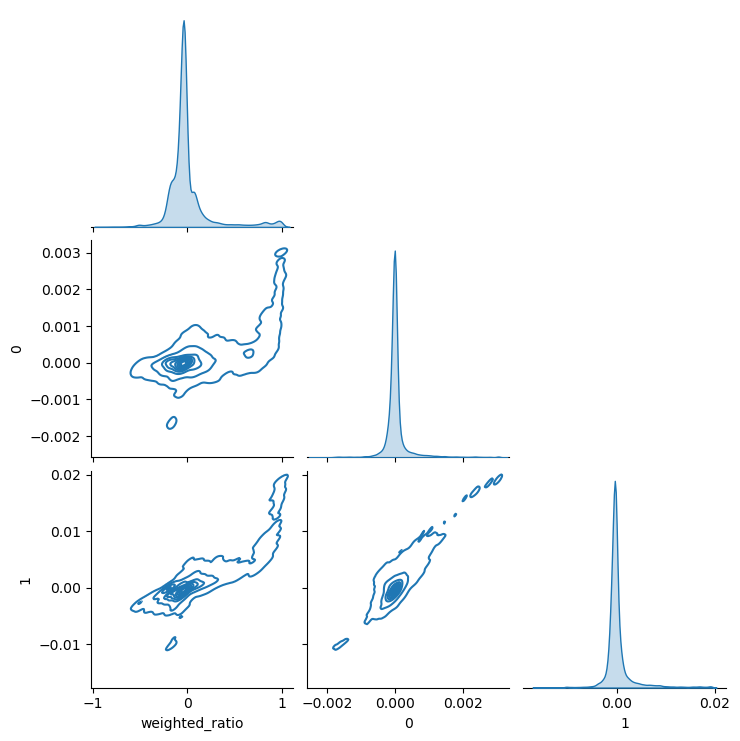

In [34]:
selected_tree_features = {}

for iteration in range(len(decision_tree_importance_dict.keys())):
    if iteration == 0:
        df = pd.DataFrame(decision_tree_importance_dict[iteration], columns=['forest_{}'.format(iteration)])
        df2 = pd.DataFrame(ridge_importances_dict[iteration], columns=['ridge_{}'.format(iteration)])
        df3 = pd.DataFrame(logReg_importances_dict[iteration], columns=['logReg_{}'.format(iteration)])
        selected = decision_tree_importance_dict[iteration][decision_tree_importance_dict[iteration] > 0]
        selected_tree_features[iteration] = selected
    else:
        df['forest_{}'.format(iteration)] = decision_tree_importance_dict[iteration]
        df2['ridge_{}'.format(iteration)] = ridge_importances_dict[iteration]
        df3['logReg_{}'.format(iteration)] = logReg_importances_dict[iteration]
        selected = decision_tree_importance_dict[iteration][decision_tree_importance_dict[iteration] > 0]
        selected_tree_features[iteration] = selected


tree_feature_counter_df = {}
#print (selected_tree_features)
for iteration in selected_tree_features.keys():
    if len(selected_tree_features[iteration].index) > 1:
        for feature in selected_tree_features[iteration].index:
            if feature not in tree_feature_counter_df.keys():
                tree_feature_counter_df[feature] = 1
            else:
                tree_feature_counter_df[feature] += 1
    else:
        if selected_tree_features[iteration].index[0] not in tree_feature_counter_df.keys():
            tree_feature_counter_df[selected_tree_features[iteration].index[0]] = 1
        else:
            tree_feature_counter_df[selected_tree_features[iteration].index[0]] += 1

tree_feature_counter_df = pd.DataFrame.from_dict(tree_feature_counter_df, orient='index', columns=['count'])
#print (tree_feature_counter_df.sort_values(by='count', ascending=False)[:100])

#merge df2 and df3
ml_summary_df = pd.concat([df2, df3],axis=1)
#print (ml_summary_df)

average_importance_ridge = df2.mean(axis=1)
average_rank_ridge = average_importance_ridge.rank(ascending=False)
#print (average_importance_ridge.sort_values(ascending=False)[:int(len(average_importance_ridge)*0.05)])
print (average_importance_ridge['GC_00001531'])
print (average_rank_ridge['GC_00001531'])

average_importance_logReg = df3.mean(axis=1)
average_rank_logReg = average_importance_logReg.rank(ascending=False)
#print (average_importance_logReg.sort_values(ascending=False)[:int(len(average_importance_logReg)*0.05)])
print (average_importance_logReg['GC_00001531'])
print (average_rank_logReg['GC_00001531'])

plotting_data = pd.concat([weighted_purity_df.loc[:, 'weighted_ratio'], average_importance_ridge, average_importance_logReg], axis=1)

sns.pairplot(plotting_data, kind='kde', corner=True)
plt.show()



In [35]:
#if not stored, save to csv the dataframes of tree_feature_counter_df, average_importance_ridge, average_importance_logReg
#Get features that are high in both the ridge and logistic regression
#Pairplot their weighted ratio with both the ridge and logistic regression importance. Ideally, we should see both high weighted ratio and low weighted ratio features with high importance in both ridge and logistic regression.
#Based on their weighted ratio, we can decide whether they are enriched or depleted in sphingo genomes.
#Get the annotation for both groups
#Plot per KO, KEGG, PFAM, COG, CAZy, description their weighted ratio and their importance

if not os.path.isfile('{}tree_feature_counter_df.tsv'.format(output_dir)):
    tree_feature_counter_df.to_csv('{}tree_feature_counter_df.tsv'.format(output_dir), sep='\t')

if not os.path.isfile('{}average_importance_ridge.tsv'.format(output_dir)):
    average_importance_ridge.to_csv('{}average_importance_ridge.tsv'.format(output_dir), sep='\t')

if not os.path.isfile('{}average_importance_logReg.tsv'.format(output_dir)):
    average_importance_logReg.to_csv('{}average_importance_logReg.tsv'.format(output_dir), sep='\t')

average_rank_ridge = average_importance_ridge.rank(ascending=False)
average_rank_logReg = average_importance_logReg.rank(ascending=False)

percentile_ridge = average_rank_ridge[average_rank_ridge < int(len(average_rank_ridge)*0.05)]
percentile_logReg = average_rank_logReg[average_rank_logReg < int(len(average_rank_logReg)*0.05)]

#print (average_importance_ridge.loc[percentile_ridge.index])
#print (average_importance_logReg.loc[percentile_logReg.index])

shared_important_features = list(set(percentile_ridge.index).intersection(set(percentile_logReg.index)))
combined_important_features = list(set(percentile_ridge.index).union(set(percentile_logReg.index)))
print (len(combined_important_features))
print (len(shared_important_features))

combined_sphingo_enriched = []
combined_sphingo_depleted = []

for gc in combined_important_features:
    if weighted_purity_df.loc[gc, 'weighted_ratio'] > 0:
        combined_sphingo_enriched.append(gc)
    else:
        combined_sphingo_depleted.append(gc)

print (len(combined_sphingo_enriched))
print (len(combined_sphingo_depleted))

for gc in combined_sphingo_enriched:
    #print (gc)
    #if gc in annotation_dict_COG_reformat.keys():
    #    print (annotation_dict_COG_reformat[gc])
    #if gc in annotation_dict_PFAM_reformat.keys():
    #    print (annotation_dict_PFAM_reformat[gc])
    #if gc in annotation_dict_KEGG_reformat.keys():
    #    print (annotation_dict_KEGG_reformat[gc])
    if gc in annotation_dict_CAZy_reformat.keys():
        print (annotation_dict_CAZy_reformat[gc])
    #if gc in annotation_dict_description_reformat.keys():
    #    print (annotation_dict_description_reformat[gc])
    

print (cazyme_per_genome)


2286
1418
2133
153
GH102
GT51
GH13
GH43
GT39
GT28
GT20
CE10
GH3
GT51
GT35
GT28
CE10
GT5
GH3
GT51
GH3
GT26
GH31
GT2
GT4
GT51
GH23
CE1
GT51
CBM48,GH13
CE10
GH5,GH9
GH51
GT2
GT28
GT2
GH32,GH68
GT4
GH43,GH51
          AA10,CBM73,GH5,GH9  GH23  CBM42,GH54  GH47  GT2  GH37  GH8  GH88   
layer                                                                        
CALOFZ02                   0     1           0     0    7     0    1     0  \
CALOGA02                   0     1           0     0    3     1    0     0   
CALOGB02                   0     1           0     0    6     1    3     0   
CALOGC02                   0     1           0     0   15     0    1     0   
CALOGD02                   0     1           0     0   15     0    1     0   
...                      ...   ...         ...   ...  ...   ...  ...   ...   
S65                        0     0           1     0    2     0    0     0   
S7                         1     1           0     0    3     0    0     0   
S71             

          A   B     C    D     E    F     G     H     I    J  ...  R     S   
enriched  0   3   107   29   175   43   128    95   101  108  ...  0   474  \
depleted  0   0    11    0    20    1     8     5    13    1  ...  0    39   
neutral   5  10  1504  348  2690  569  2270  1069  1282  952  ...  0  8078   

             T    U    V  W  X  Y   Z     -  
enriched   101   69   29  0  0  0   0   140  
depleted     4    2    1  0  0  0   0     2  
neutral   1696  835  425  4  0  1  19  3393  

[3 rows x 27 columns]
                 A         B         C         D         E         F   
enriched  0.000000  0.001316  0.046930  0.012719  0.076754  0.018860  \
depleted  0.000000  0.000000  0.064706  0.000000  0.117647  0.005882   
neutral   0.000138  0.000277  0.041617  0.009629  0.074435  0.015745   

                 G         H         I         J  ...  R         S         T   
enriched  0.056140  0.041667  0.044298  0.047368  ...  0  0.207895  0.044298  \
depleted  0.047059  0.029412  0

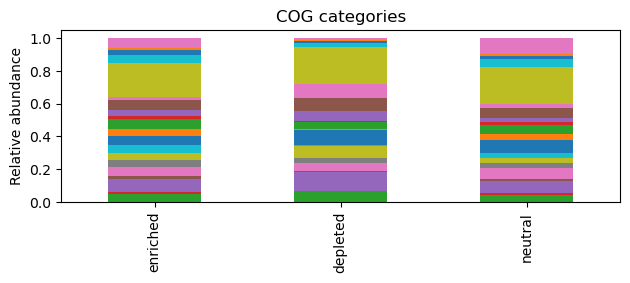

In [36]:
#make table where you count the cog counts for gc in combined_sphingo_enriched, combined_sphingo_depleted, and all GCs minus the combined_sphingo_enriched and combined_sphingo_depleted

cog_table = pd.DataFrame(0, index=['enriched', 'depleted', 'neutral'], columns=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '-'])

annotation_dict_COG_reformat_keys = annotation_dict_COG_reformat.keys()

for gc in gene_cluster_presence_absence.columns:
    if gc in annotation_dict_COG_reformat_keys:
        if gc in combined_sphingo_enriched:
            if len(annotation_dict_COG_reformat[gc]) == 1:
                cog_table.loc['enriched', annotation_dict_COG_reformat[gc]] += 1
            else:
                for annot in annotation_dict_COG_reformat[gc]:
                    cog_table.loc['enriched', annot] += 1
        elif gc in combined_sphingo_depleted:
            if len(annotation_dict_COG_reformat[gc]) == 1:
                cog_table.loc['depleted', annotation_dict_COG_reformat[gc]] += 1
            else:
                for annot in annotation_dict_COG_reformat[gc]:
                    cog_table.loc['depleted', annot] += 1
        else:
            if len(annotation_dict_COG_reformat[gc]) == 1:
                cog_table.loc['neutral', annotation_dict_COG_reformat[gc]] += 1
            else:
                for annot in annotation_dict_COG_reformat[gc]:
                    cog_table.loc['neutral', annot] += 1

print (cog_table)

#make 3 stacked barplots for each COG category, one for enriched, one for depleted, one for neutral with the relative abundance of the COG category.


cog_table.loc['enriched'] = cog_table.loc['enriched']/cog_table.loc['enriched'].sum()
cog_table.loc['depleted'] = cog_table.loc['depleted']/cog_table.loc['depleted'].sum()
cog_table.loc['neutral'] = cog_table.loc['neutral']/cog_table.loc['neutral'].sum()

print (cog_table)

fig, ax = plt.subplots()
cog_table.plot.bar(stacked=True, ax=ax)
ax.set_title("COG categories")
ax.set_ylabel("Relative abundance")
fig.tight_layout()
#remove the legend
ax.legend().remove()
plt.show()

dict_keys(['GC_00026744', 'GC_00023617', 'GC_00009660', 'GC_00009817', 'GC_00010540', 'GC_00028975', 'GC_00031343', 'GC_00018509', 'GC_00026617', 'GC_00010020', 'GC_00007002', 'GC_00008764', 'GC_00010132', 'GC_00015897', 'GC_00024503', 'GC_00013317', 'GC_00018218', 'GC_00001349', 'GC_00020664', 'GC_00035275', 'GC_00002052', 'GC_00009546', 'GC_00007911', 'GC_00007467', 'GC_00035119', 'GC_00002690', 'GC_00015731', 'GC_00017133', 'GC_00003674', 'GC_00024315', 'GC_00009225', 'GC_00020615', 'GC_00002432', 'GC_00002496', 'GC_00022256', 'GC_00001471', 'GC_00027717', 'GC_00009066', 'GC_00001728', 'GC_00005858', 'GC_00002211', 'GC_00003912', 'GC_00003526', 'GC_00005149', 'GC_00007496', 'GC_00000396', 'GC_00023492', 'GC_00009478', 'GC_00029383', 'GC_00008479', 'GC_00034769', 'GC_00027891', 'GC_00032525', 'GC_00022586', 'GC_00031949', 'GC_00018587', 'GC_00020782', 'GC_00005952', 'GC_00013883', 'GC_00021610', 'GC_00022824', 'GC_00025937', 'GC_00035307', 'GC_00019761', 'GC_00005235', 'GC_00018022',

/tmp/ipykernel_2769852/3294934617.py:61: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


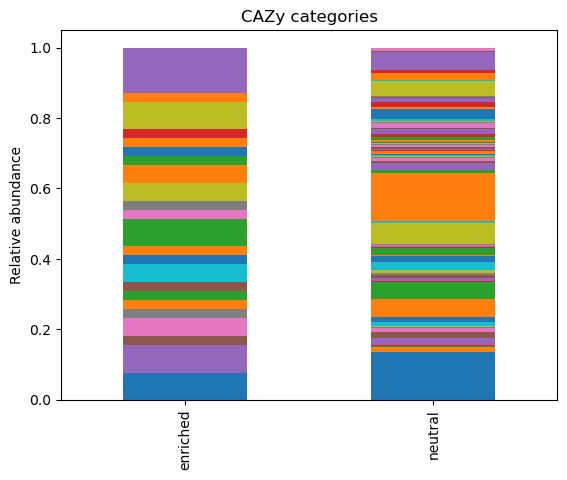

In [37]:
#make table where you count the cazyme for gc in combined_sphingo_enriched, combined_sphingo_depleted, and all GCs minus the combined_sphingo_enriched and combined_sphingo_depleted

annotation_dict_CAZy_reformat_keys = annotation_dict_CAZy_reformat.keys()
print (annotation_dict_CAZy_reformat_keys)
print (annotation_dict_CAZy_reformat.values())
cazymes_in_db = list(set(annotation_dict_CAZy_reformat.values()))
cazyme_list = []
for cazyme in cazymes_in_db:
    if len(cazyme.split(','))>1:
        for caz in cazyme.split(','):
            if caz not in cazyme_list:
                cazyme_list.append(caz)
    elif cazyme not in cazyme_list:
        cazyme_list.append(cazyme)

print (cazyme_list)

cazyme_table = pd.DataFrame(0, index=['enriched', 'neutral'], columns=cazyme_list)

for gc in gene_cluster_presence_absence.columns:
    if gc in annotation_dict_CAZy_reformat_keys:
        cazyme = annotation_dict_CAZy_reformat[gc]
        if gc in combined_sphingo_enriched:
            if len(cazyme.split(',')) == 1:
                cazyme_table.loc['enriched', cazyme] += 1
            else:
                for caz in cazyme.split(','):
                    cazyme_table.loc['enriched', caz] += 1
        #elif gc in combined_sphingo_depleted:
        #    if len(cazyme.split(',')) == 1:
        #        cazyme_table.loc['depleted', cazyme] += 1
        #    else:
        #        for caz in cazyme.split(','):
        #            cazyme_table.loc['depleted', caz] += 1
        elif gc not in combined_sphingo_depleted:
            if len(cazyme.split(',')) == 1:
                cazyme_table.loc['neutral', cazyme] += 1
            else:
                for caz in cazyme.split(','):
                    cazyme_table.loc['neutral', caz] += 1

print (cazyme_table)
for cazyme in cazyme_table.columns:
    if cazyme_table.loc['enriched', cazyme] != 0:
        print (cazyme, cazyme_table.loc['enriched', cazyme], cazyme_table.loc['neutral', cazyme])
print (cazyme_table.sum(axis=1))
print (len(combined_sphingo_enriched), len(combined_sphingo_depleted), len(gene_cluster_presence_absence.columns), len(combined_sphingo_enriched)/len(gene_cluster_presence_absence.columns), len(combined_sphingo_depleted)/len(gene_cluster_presence_absence.columns))

#make 3 stacked barplots for each CAZy category, one for enriched, one for depleted, one for neutral with the relative abundance of the CAZy category.

cazyme_table.loc['enriched'] = cazyme_table.loc['enriched']/cazyme_table.loc['enriched'].sum()
#cazyme_table.loc['depleted'] = cazyme_table.loc['depleted']/cazyme_table.loc['depleted'].sum()
cazyme_table.loc['neutral'] = cazyme_table.loc['neutral']/cazyme_table.loc['neutral'].sum()

print (cazyme_table)

fig, ax = plt.subplots()
cazyme_table.plot.bar(stacked=True, ax=ax)
ax.set_title("CAZy categories")
ax.set_ylabel("Relative abundance")
fig.tight_layout()
#remove the legend
ax.legend().remove()
plt.show()


In [38]:
for cazyme in cazyme_table.columns:
    print (cazyme, round(cazyme_table.loc['enriched', cazyme], 4), round(cazyme_table.loc['neutral', cazyme], 4), round(cazyme_table.loc['enriched', cazyme]/cazyme_table.loc['neutral', cazyme], 4))

GT2 0.0769 0.1356 0.5671
GT1 0.0 0.0126 0.0
GH65 0.0 0.0047 0.0
GH38 0.0 0.0016 0.0
GT28 0.0769 0.0205 3.7515
GH23 0.0256 0.0158 1.6256
GH51 0.0513 0.0126 4.0641
GT39 0.0256 0.0032 8.1282
GT73 0.0 0.0032 0.0
GT9 0.0 0.0095 0.0
GH18 0.0 0.0158 0.0
GH5 0.0256 0.0521 0.4926
GH9 0.0256 0.0473 0.5419
GH47 0.0 0.0016 0.0
GT19 0.0 0.0095 0.0
CE1 0.0256 0.0079 3.2513
GH121 0.0 0.0016 0.0
GH101 0.0 0.0047 0.0
GH77 0.0 0.0095 0.0
GH43 0.0513 0.0221 2.3223
GH32 0.0256 0.0174 1.4779
GH68 0.0256 0.0016 16.2564
CE10 0.0769 0.0205 3.7515
GH88 0.0 0.0032 0.0
PL8 0.0 0.0016 0.0
PL11 0.0 0.0016 0.0
GT35 0.0256 0.0016 16.2564
GT20 0.0256 0.0032 8.1282
GH13 0.0513 0.0599 0.8556
GH30 0.0 0.0047 0.0
GT89 0.0 0.0016 0.0
GT4 0.0513 0.1356 0.3781
GH102 0.0256 0.0079 3.2513
GT85 0.0 0.0016 0.0
GH103 0.0 0.0205 0.0
CBM20 0.0 0.0032 0.0
GT30 0.0 0.011 0.0
GT56 0.0 0.0016 0.0
GH94 0.0 0.0032 0.0
GT36 0.0 0.0016 0.0
GT25 0.0 0.0047 0.0
GH37 0.0 0.0063 0.0
CBM42 0.0 0.0016 0.0
GH54 0.0 0.0016 0.0
GT70 0.0 0.0047 0.0

In [39]:
for cog in cog_table.columns:
    print (cog)
    print (round(cog_table.loc['enriched', cog], 4), round(cog_table.loc['depleted', cog], 4), round(cog_table.loc['neutral', cog], 4), round(cog_table.loc['enriched', cog]/cog_table.loc['neutral', cog], 4))

A
0.0 0.0 0.0001 0.0
B
0.0013 0.0 0.0003 4.7551
C
0.0469 0.0647 0.0416 1.1277
D
0.0127 0.0 0.0096 1.3209
E
0.0768 0.1176 0.0744 1.0312
F
0.0189 0.0059 0.0157 1.1978
G
0.0561 0.0471 0.0628 0.8938
H
0.0417 0.0294 0.0296 1.4086
I
0.0443 0.0765 0.0355 1.2487
J
0.0474 0.0059 0.0263 1.7982
K
0.0557 0.0941 0.0807 0.6906
L
0.0417 0.0059 0.0358 1.1637
M
0.0601 0.0412 0.0596 1.0081
N
0.0224 0.0059 0.0168 1.3296
O
0.0368 0.0588 0.0239 1.5428
P
0.0566 0.0824 0.0603 0.9384
Q
0.0241 0.0824 0.027 0.8932
R
0 0 0 nan
S
0.2079 0.2294 0.2235 0.9301
T
0.0443 0.0235 0.0469 0.9439
U
0.0303 0.0118 0.0231 1.3098
V
0.0127 0.0059 0.0118 1.0816
W
0.0 0.0 0.0001 0.0
X
0 0 0 nan
Y
0.0 0.0 0.0 0.0
Z
0.0 0.0 0.0005 0.0
-
0.0614 0.0118 0.0939 0.654


/tmp/ipykernel_2769852/102094520.py:3: RuntimeWarning: invalid value encountered in scalar divide
  print (round(cog_table.loc['enriched', cog], 4), round(cog_table.loc['depleted', cog], 4), round(cog_table.loc['neutral', cog], 4), round(cog_table.loc['enriched', cog]/cog_table.loc['neutral', cog], 4))


In [40]:
sphingo_incidence_histogram = []
non_sphingo_incidence_histogram = []

for gc in purity_df.index:
    ps = purity_df.loc[gc, 'purity_sphingo']
    pns = purity_df.loc[gc, 'purity_non_sphingo']
    if ps > pns:
        if pns > 0:
            sphingo_incidence_histogram.append((ps/pns)*((ps+pns)/2))
        else:
            sphingo_incidence_histogram.append((ps/(1/len(non_sphingo_list)))*((ps+(1/len(non_sphingo_list)))/2))
    else:
        if ps > 0:
            non_sphingo_incidence_histogram.append((pns/ps)*((ps+pns)/2))
        else:
            non_sphingo_incidence_histogram.append((pns/(1/len(sphingo_list)))*((pns+(1/len(sphingo_list)))/2))

#sns.histplot(sphingo_incidence_histogram)
#plt.show()

#sns.histplot(non_sphingo_incidence_histogram)
#plt.show()

#print (sorted(sphingo_incidence_histogram, reverse=True))
#print (sorted(non_sphingo_incidence_histogram, reverse=True))

